In [1]:
from dotenv import load_dotenv
load_dotenv()
import os
from typing import Dict
from langchain_groq import ChatGroq
from typing_extensions import TypedDict
from pydantic import BaseModel,Field
from typing import List

#os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


llm=ChatGroq(model="llama-3.1-8b-instant")
#llm = ChatOpenAI(model="gpt-4o")
result=llm.invoke("Hello")
result

c:\Users\nehaa\SDLCAgentic\env\Lib\site-packages\pydantic\v1\main.py:1054: UserWarning: LangSmith now uses UUID v7 for run and trace identifiers. This warning appears when passing custom IDs. Please use: from langsmith import uuid7
            id = uuid7()
Future versions will require UUID v7.
  input_data = validator(cls_, input_data)


AIMessage(content='Hello. How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 36, 'total_tokens': 46, 'completion_time': 0.010312338, 'completion_tokens_details': None, 'prompt_time': 0.001906842, 'prompt_tokens_details': None, 'queue_time': 0.089200089, 'total_time': 0.01221918}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_4387d3edbb', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--75bc2ff1-3882-4c05-91be-f570ea3a404b-0', usage_metadata={'input_tokens': 36, 'output_tokens': 10, 'total_tokens': 46})

In [2]:
from typing_extensions import Annotated,Literal,Optional
from pydantic import BaseModel,Field
from  langgraph.graph import StateGraph,START,END
from IPython.display import Image , display
from langchain_core.messages import HumanMessage,SystemMessage,AIMessage
from langgraph.checkpoint.memory import MemorySaver


In [3]:
class SDLC(BaseModel):
    requirements:str = None
    User_story:str=None
    design_documents:str=None
    Feedback:str="no feedback yet"
    user_story_feedback: str = Field(default="no story yet")
    generated_code: str = None 
    generated_testcase:str = None
    design_feedback:str=None
    test_case_feedback: str= Field(default ="No test case feedback yet.")
    code_review:str = Field(default="No code feedback yet.") 
    approval_status: str = Field(default="pending")
    design_approval_status: str = Field(default="pending")
    code_approval_status: str = Field(default="pending")
    testcase_approval_status :str = Field(default="pending")
    QA_feedback:str=None
    qa_testing:str=None
    QA_approval_status:str = Field(default ="pending")
    qa_test_results: Optional[str] = None
    
    


In [4]:
class SDLC(BaseModel):
    """State model for SDLC workflow - All fields properly typed"""
    
    # Required field
    requirements: str
    
    # Optional artifact fields with proper typing
    User_story: Optional[str] = None
    design_documents: Optional[str] = None
    generated_code: Optional[str] = None
    generated_testcase: Optional[str] = None
    qa_test_results: Optional[str] = None
    
    # Feedback fields with defaults
    Feedback: str = Field(default="no feedback yet")
    user_story_feedback: str = Field(default="No user story feedback yet.")
    design_feedback: str = Field(default="No design feedback yet.")
    code_review: str = Field(default="No code feedback yet.")
    test_case_feedback: str = Field(default="No test case feedback yet.")
    QA_feedback: str = Field(default="No QA feedback yet.")
    
    # Approval status fields
    approval_status: str = Field(default="pending")
    design_approval_status: str = Field(default="pending")
    code_approval_status: str = Field(default="pending")
    testcase_approval_status: str = Field(default="pending")
    QA_approval_status: str = Field(default="pending")



In [5]:
def Initial_requirements(state:SDLC)->SDLC:
    """user provide intial input collect project requiremntfrom user_input"""
    if not state.requirements:
        state.requirements=input("enter project requirements:")
        return state.model_copy(update={"requirements": state.requirements})

In [6]:
def User_story(state:SDLC)->SDLC:
    """write detail user story according given input and feedback"""
    
    base_prompt = [
        "Generate a detailed user story with:",
        "1. User Story (As a [role], I want [feature], so that [benefit])",
        "2. Acceptance Criteria (numbered list)",
        "3. Error Handling Scenarios (must include):",
        "   - System errors",
        "   - User input errors",
        "   - Network/resource errors",
        "4. Definition of Done",
        f"\nRequirements: {state.requirements}"
    ]
    if state.user_story_feedback!="no  feedback yet.":
        feedback = state.user_story_feedback
        if "reject:" in feedback:
            feedback = feedback.replace("reject:", "").strip()
            print(f"Processing Feedback: {feedback}")
            
            base_prompt.extend([
                "\nPrevious Story:",
                state.User_story,
                "\nFeedback to address:",
                feedback,
                "\nRevision Guidelines:",
                "1. Address the feedback completely",
                "2. Maintain existing good elements",
                "3. Include specific error scenarios",
                "4. Ensure measurable acceptance criteria"
            ])


    messages= [

     SystemMessage(content="\n".join([
         
        "you are expert agile coach for writing user story",
        "focus on creating compehnsive with error handling,",
        "each rivision should improve upon privious one"

    ])),
    HumanMessage(content="\n".join(base_prompt))
    ]
    try:
        revised_story = llm.invoke(messages).content
        #print("\nGenerated User Story:\n")
        print(revised_story)
        print(f"✅ User Story Generated ({len(revised_story)} chars)")
        print(f"Preview: {revised_story[:150]}...")
        # Update state with new story
        return state.model_copy(update={
         "User_story": revised_story,
         "approval_status": "pending"
         })

    except Exception as e:
        print(f"Error in story generation: {e}")
        return state.model_copy(update={
            "feedback": f"Error in story generation: {str(e)}"
        })

In [7]:
def product_owner_review(state: SDLC) -> SDLC:
    """Handle product owner review of user story"""
   
    print("PRODUCT OWNER REVIEW - USER STORY")
    print(f"User Story exists: {bool(state.User_story)}")
    print(f"User Story length: {len(state.User_story) if state.User_story else 0}")
    
    print("\nCurrent User Story:")
    print(state.User_story)
    if not state.User_story:
        print("ERROR: No user story to review!")
        return state
    
    print(f"\nUser Story Preview:\n{state.User_story[:200]}...")
    
    while True:
        feedback = input("\nDo you approve this user story? (yes/no): ").strip().lower()
        
        if feedback in ("yes", "ya", "y"):
            print(" User story approved!")
            return state.model_copy(update={
                   "approval_status": "approved",
                   "user_story_feedback": "No user story feedback yet."
                   })

        
        elif feedback in ("no", "not", "n"):
            user_feedback = input("\nProvide feedback for revision: ").strip()
            if user_feedback:
                print(f" Feedback recorded: {user_feedback}")
                return state.model_copy(update={
                    "approval_status": "rejected",
                    "user_story_feedback": user_feedback
                })
            else:
                print("  Please provide feedback to improve the user story.")
        else:
            print(" Invalid input. Please enter 'yes' or 'no'.")




In [8]:
def design_document(state:SDLC)->SDLC:
    """create designe document according to user story and feedback"""
     
    print("NODE: create_design_document")
    
    print(f"User Story exists: {bool(state.User_story)}")
    print(f"Design Feedback: {state.design_feedback}")
    if not state.User_story:
        print("User stories missing. Cannot generate design document.")
        return state

    # Base prompt
    base_content = [
        "# Design Document Template",
        "",
        "Create a detailed design document for these user stories:",
        str(state.User_story),
        "",
        "## Sections to Include:",
        "1. System Architecture Overview",
        "2. Component Design",
        "3. Data Models & Database Schema",
        "4. API Specifications (endpoints, request/response)",
        "5. Security & Authentication",
        "6. Technology Stack",
        "",
        "",
        "## Important Rules",
        "- Do not include any testing sections",
        "- Do not include error handling unless explicitly requested",
        "- Use markdown formatting",
        "",

    ]
    if state.design_feedback != "No design feedback yet.":
        print(f" Incorporating feedback: {state.design_feedback}")
        base_content.extend([
            "",
            "## Previous Design:",
            str(state.design_documents) if str(state.design_documents) else "None",
            "",
            "## Feedback to Address:",
            str(state.design_feedback)
        ])

   
    messages = [
        SystemMessage(content="\n".join([
            "You are a software architect creating clear, structured design documents.",
            "Focus on practical, implementable designs.",
            "Use markdown formatting for better readability.",
            "Strictly follow the requested sections only.",
            "Remove any sections mentioned in feedback."
        ])),
        HumanMessage(content="\n".join(base_content))
    ]
    

    try:
        # Generate design document
        design_doc = llm.invoke(messages).content
        print("Design Document Generated!")
        print(design_doc)

        # Store the updated design document
        return state.model_copy(update={
            "design_documents": design_doc,
            "design_approval_status": "pending"
            
        })

    except Exception as e:
        print(f"\nError generating design document: {str(e)}")
        return state


#step 5: create a design review
def design_review(state: SDLC )-> SDLC:
  """Review design documents and approve or reject them."""
  print("\nCurrent Design Document:")
  if not state.design_documents:
        print(" No design document to review!")
        return state
  print(state.design_documents[:300] + "...")
  while True:
      design_feedback = input("\DO you Approve this design document (yes or no):").strip()
      if design_feedback in ("yes","ya"):
          print("Design document approve")
          return state.model_copy(update={
              "design_approval_status":"approved",
              "design_feedback":" yes!"
              
          })
      elif design_feedback in ("not", "no", "n"):
            design_feedback = input("\nProvide feedback: ").strip()
            if design_feedback:
                print(f" Design feedback recorded: {design_feedback}")
                return state.model_copy(update={
                    "design_approval_status": "rejected",
                    "design_feedback": design_feedback
                })
            else:
                print("⚠️ Please provide feedback.")
      else:
            print("❌ Invalid input. Please enter 'yes' or 'no'.")

   

In [9]:
              
def generate_code(state: SDLC) -> SDLC:  
    """Generate code based on design document"""
    
    print("\n" + "="*60)
    print("NODE: generate_code")
    print("="*60)
    print(f"Design doc exists: {bool(state.design_documents)}")
    
    if not state.design_documents:
        print(" Design document missing. Cannot generate code.")
        return state
    
    
    base_prompt = [
        "Generate production-ready code based on this design document:",
        state.design_documents,
        "",
        "## Requirements:",
        "1. Write clean and well-structured code",
        "2. Include proper error handling",
        "3. Add comprehensive comments",
        "4. Follow best practices and design patterns",
        "5. Include input validation",
        "6. Add logging where appropriate",
        "7. Make code modular and testable",
        "",
        "## Code Structure:",
        "- Main application logic",
        "- Helper functions/classes",
        "- Configuration management",
        "- Error handling utilities",
        "",
        "Generate complete, runnable code with all necessary imports and setup."
    ]
    
   
    if state.code_approval_status!= "No code feedback yet.":
        print(f" Incorporating feedback: {state.code_review}")
        base_prompt.extend([ 
            "",
            "## Previous Code:",
            state.generated_code if state.generated_code else "None",
            "",
            "## Feedback to Address:",
            state.code_review,
            "",
            "Revise the code to address all feedback points."
        ])

    messages = [
        SystemMessage(content="\n".join([
            "You are an expert software developer writing production-ready code.",
            "Focus on code quality, maintainability, and best practices.",
            "Include proper error handling and validation.",
            "Write code that is well-commented and easy to understand.",
            "Follow SOLID principles and design patterns where appropriate."
        ])),
        HumanMessage(content="\n".join(base_prompt))  
    ]
    
    try:
        generated_code = llm.invoke(messages).content
        print(" CODE GENERATED!")
        print(generated_code[:200] + "...")
        
        return state.model_copy(update={
            "generated_code": generated_code,  
            "code_approval_status": "pending"
        })

    except Exception as e:
        print(f"Error generating code: {str(e)}")
        return state


In [10]:
def code_review(state: SDLC) -> SDLC:
    """Review generated code and collect feedback"""
    print("\n NODE: code_review - STARTING") 
    if not state.generated_code:  
        print(" No code to review!")
        return state 
    print(f"Design approval status: {state.design_approval_status}") 
    print("SENIOR DEVELOPER REVIEW - CODE")
    print(state.generated_code[:300] + "...")
    print("\nGenerated Code:")
    print(state.generated_code)
    
    
    while True:
        code_feedback = input("\nDo you approve this code? (yes/no): ").strip().lower()
        
        if code_feedback in ("yes", "ya", "y"):
            print(" Code approved! Ready for deployment!")
            return state.model_copy(update={
                "code_approval_status": "approved",
                "code_feedback": "No code feedback yet."
            })
        
        elif code_feedback in ("no", "not", "n"):
            code_feedback = input("\nProvide feedback for code revision: ").strip()
            if code_feedback:
                print(f"✗ Code feedback recorded: {code_feedback}")
                return state.model_copy(update={
                    "code_approval_status": "rejected",
                    "code_feedback": code_feedback
                })
            else:
                print("  Please provide feedback to improve the code.")
        else:
            print(" Invalid input. Please enter 'yes' or 'no'.")




In [12]:
def user_story_routing(state: SDLC) -> Literal["User_story", "design_document"]:
    """Route based on user story approval status"""
    if state.approval_status == "approved":
        print("\n Routing to: design_document")
        return "design_document"
    else:
        print("\n Routing to: User_story (for revision)")
        return "User_story"


def design_routing(state: SDLC) -> Literal["design_document", "generate_code"]:
    """Route based on design approval status"""
    print(f"\n ROUTING: design_routing") 
    print(f"   Design approval: {state.design_approval_status}") 
    if state.design_approval_status == "approved":
        print(f"\n  Routing to: generate_code")
        return "generate_code"
    else:
        print(f"\n Routing to: design_document (for revision)")
        return "design_document"


def code_routing(state: SDLC) -> Literal["generate_code","genrated_test_case"]:
    """Route based on code approval status"""
    if state.code_approval_status == "approved":
        print("\n  Routing to: END (workflow complete)")
        return "genrated_test_case"
    else:
        print("\n Routing to: generate_code (for revision)")
        return "generate_code"

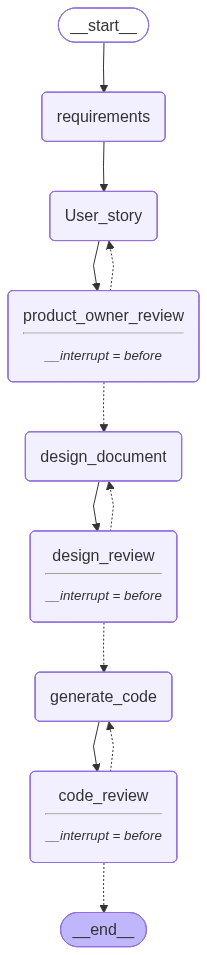

In [13]:
builder = StateGraph(SDLC)

# Add all nodes
builder.add_node("requirements", Initial_requirements)
builder.add_node("User_story", User_story)
builder.add_node("product_owner_review",product_owner_review)
builder.add_node("design_document", design_document)
builder.add_node("design_review", design_review)
builder.add_node("generate_code", generate_code)
builder.add_node("code_review", code_review)

# Add edges
builder.add_edge(START, "requirements")
builder.add_edge("requirements", "User_story")
builder.add_edge("User_story", "product_owner_review")

# User story approval routing
builder.add_conditional_edges(
    "product_owner_review",
    user_story_routing,
    {
        "design_document": "design_document",
        "User_story": "User_story"
    }
)

# Design document flow
builder.add_edge("design_document", "design_review")

# Design approval routing
builder.add_conditional_edges(
    "design_review",
    design_routing,
    {
        "generate_code": "generate_code",
        "design_document": "design_document"
    }
)

# Code generation flow
builder.add_edge("generate_code", "code_review")

# Code approval routing
builder.add_conditional_edges(
    "code_review",
    code_routing,
    {
        "generate_code": "generate_code",
        END: END
    }
)

# Compile graph
memory = MemorySaver()
graph = builder.compile(
    interrupt_before=['product_owner_review', 'design_review', 'code_review'],
    checkpointer=memory
)
display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
config = {"configurable": {"thread_id": "test-thread"}}
initial_state = SDLC(requirements= "Build a login feature")

print("Starting SDLC workflow with input requirement...")
result = graph.invoke(initial_state, config=config)
print("Interrupted at product owner review:", result)

print("Resuming after approval input...")
result = graph.invoke(None, config=config)
print("Workflow completed with output:", result)
result = graph.invoke(None,config=config)
print("Workflow completed with output:", result)

Starting SDLC workflow with input requirement...
**User Story**

As a **registered user**, I want to be able to log in to the application, so that I can access my account and perform various actions.

**Acceptance Criteria**

1. The application displays a login form with fields for username and password.
2. The user can enter their username and password into the form.
3. When the user clicks the login button, the application verifies the username and password with the database.
4. If the username and password are valid, the application redirects the user to the dashboard.
5. If the username and password are invalid, the application displays an error message indicating that the credentials are incorrect.
6. The application handles cases where the username or password is empty.
7. The application handles cases where the username or password contains invalid characters.
8. The application handles cases where the network connection is lost during the login process.
9. The application handl

In [ ]:
def diagnostic_test():
    """Run workflow with detailed diagnostics"""
    config = {"configurable": {"thread_id": "diagnostic-test-001"}}
    initial_state = SDLC(requirements="Build a login feature with email and password authentication")
    
    print("\n" + "" + "="*59)
    print("DIAGNOSTIC TEST - FULL WORKFLOW")
    print("="*60 + "\n")
    
    # Step 1
    print("STEP 1: Initial run to user story review")
    result = graph.invoke(initial_state, config=config)
    print(f"\nState after step 1:")
    print(f"   User Story: {'✓ EXISTS' if result.get('User_story') else '✗ MISSING'}")
    print(f"   Approval Status: {result.get('approval_status')}")
    
    # Step 2
    print("\n" + "="*60)
    print(" STEP 2: User story review")
    result = graph.invoke(None, config=config)
    print(f"\nState after step 2:")
    print(f"   User Story: {'✓ EXISTS' if result.get('User_story') else '✗ MISSING'}")
    print(f"   Approval Status: {result.get('approval_status')}")
    print(f"   Design Doc: {'✓ EXISTS' if result.get('design_documents') else '✗ MISSING'}")
    print(f"   Design Approval: {result.get('design_approval_status')}")
    
    # Step 3
    print("\n" + "="*60)
    print(" STEP 3: Design review")
    result = graph.invoke(None, config=config)
    print(f"\n State after step 3:")
    print(f"   Design Doc: {'✓ EXISTS' if result.get('design_documents') else '✗ MISSING'}")
    print(f"   Design Approval: {result.get('design_approval_status')}")
    print(f"   Code: {'✓ EXISTS' if result.get('generated_code') else '✗ MISSING'}")
    print(f"   Code Approval: {result.get('code_approval_status')}")
    
    # Step 4
    print("\n" + "="*60)
    print("📍 STEP 4: Code review")
    result = graph.invoke(None, config=config)
    print(f"\n📊 FINAL State:")
    print(f"   User Story: {'✓ EXISTS' if result.get('User_story') else '✗ MISSING'}")
    print(f"   Design Doc: {'✓ EXISTS' if result.get('design_documents') else '✗ MISSING'}")
    print(f"   Code: {'✓ EXISTS' if result.get('generated_code') else '✗ MISSING'}")
    print(f"   Code Approval: {result.get('code_approval_status')}")
    
    print("\n" + "="*60)
    print(" DIAGNOSTIC TEST COMPLETE")
    print("="*60)
    
    # Show code if generated
    if result.get('generated_code'):
        print("\nGENERATED CODE:")
        print("="*60)
        print(result['generated_code'])
        print("="*60)
    
    return result

# Run diagnostic test
result = diagnostic_test()


🔬===========================================================
DIAGNOSTIC TEST - FULL WORKFLOW

📍 STEP 1: Initial run to user story review
**User Story:**

**As a** Registered User,
**I want** to be able to log in to the application with my email and password,
**so that** I can access my account and use the application's features.

**Acceptance Criteria:**

1. The user can enter their email address and password in the login form.
2. The system validates the email address and password against the stored user credentials.
3. If the email address and password are correct, the system logs the user in and redirects them to the application's home page.
4. If the email address or password is incorrect, the system displays an error message indicating that the credentials are invalid.
5. If the user is inactive for a certain period, the system logs them out and requires them to log in again.
6. The system stores the user's login credentials securely using a secure password hashing algorithm.
7. 

In [11]:
def genrated_test_case(state: SDLC) -> SDLC:
    """Generate comprehensive test cases for the code"""
    print("\n" + "="*60)
    print(" STEP 8: Test Case Generation")
    print("="*60)
    
    #  FIX: Check for generated_CODE, not generated_testcase
    if not state.generated_code:
        print("❌ ERROR: No code available to generate tests for!")
        return state
    
    print(f"✓ Code exists ({len(state.generated_code)} characters)")
    
    base_prompt = [
        "Generate comprehensive, executable test cases for this code:",
        "",
        "```",
        state.generated_code,
        "```",
        "",
        "**Test Requirements:**",
        "1. Use pytest or unittest framework",
        "2. Test all main functionality",
        "3. Include positive test cases",
        "4. Include negative/edge test cases",
        "5. Test error handling",
        "6. Use clear, descriptive test names",
        "7. Include setup and teardown if needed",
        "8. Add assertions for all expected outcomes",
        "",
        "**Format:**",
        "- Complete, runnable test file",
        "- Proper imports",
        "- Test class organization",
        "- Individual test methods"
    ]
    
    # Add revision context if feedback exists
    if state.test_case_feedback != "No test case feedback yet.":
        print(f"Incorporating feedback: {state.test_case_feedback[:100]}...")
        base_prompt.extend([
            "",
            "**Previous Test Cases:**",
            state.generated_testcase or "None",
            "",
            "**Feedback to Address:**",
            state.test_case_feedback,
            "",
            "**Instructions:** Add missing tests and fix issues mentioned in feedback."
        ])
    
    messages = [
        SystemMessage(content="\n".join([
            "You are a senior QA engineer specializing in test automation.",
            "Write thorough, maintainable test suites.",
            "Cover all functionality including edge cases.",
            "Follow testing best practices."
        ])),
        HumanMessage(content="\n".join(base_prompt))
    ]
    
    try:
        test_cases = llm.invoke(messages).content
        print(f"Test cases generated ({len(test_cases)} characters)")
        print(f" Preview:\n{test_cases[:400]}...\n")
        
        return state.model_copy(update={
            "generated_testcase": test_cases,
            "testcase_approval_status": "pending"
        })
    
    except Exception as e:
        print(f" Error generating test cases: {e}")
        return state



In [12]:
def review_testcase(state:SDLC)->SDLC:
    """Ai reviwe the genrated test caseand decide to approve or rejected"""
    print("testcase review")
    if not state.generated_testcase:
        print("no test case for review")
        return state
    print(state.generated_testcase)
    while True:

     test_case_feedback = input("\n do you approve this test case(yes\no)")

     if test_case_feedback in ("yes", "ya", "y"):
            print(" Code approved! Ready for deployment!")
            return state.model_copy(update={
                "testcase_approval_status": "approved",
                "test_case_feedback": "No code feedback yet."
            })
        
     elif test_case_feedback in ("no", "not", "n"):
            test_case_feedback = input("\nProvide feedback for code revision: ").strip()
            if test_case_feedback:
                print(f"✗ Code feedback recorded: {test_case_feedback}")
                return state.model_copy(update={
                    "testcase_approval_status": "rejected",
                    "test_case_feedback": test_case_feedback
                })
            else:
                print("  Please provide feedback to improve the code.")
     else:
            print(" Invalid input. Please enter 'yes' or 'no'.")



In [16]:
def user_story_routing(state: SDLC) -> Literal["User_story", "design_document"]:
    if state.approval_status == "approved":
        return "design_document"
    return "User_story"


def design_routing(state: SDLC) -> Literal["design_document", "generate_code"]:
    if state.design_approval_status == "approved":
        return "generate_code"
    return "design_document"


def code_routing(state: SDLC) -> Literal["generate_code", "genrated_test_case"]:
    """Route after code review - FIXED"""
    print(f"\n ROUTING: code_routing")
    print(f"   Code Approval: {state.code_approval_status}")
    
    if state.code_approval_status == "approved":
        print("    Going to: genrated_test_case")
        return "genrated_test_case"  
    else:
        print("  Going to: generate_code")
        return "generate_code"


def test_case_routing(state: SDLC) -> Literal["genrated_test_case", END]:
    """Route after test case review """
    print(f"\ ROUTING: test_case_routing")
    print(f"   Test Case Approval: {state.testcase_approval_status}")
    
    if state.testcase_approval_status == "approved":
        print(" Going to: END")
        return END  
    else:
        print(" Going to: genrated_test_case")
        return "genrated_test_case"

In [13]:
def testcase_review_route(state:SDLC)->Literal['generate_code',END]:
    """Route based on testcase approval status"""
    print(f"\n ROUTING: testcase_routing") 
    print(f"testcase approval: {state.testcase_approval_status}") 
    if state.testcase_approval_status == "approved":
        print(f"\n  Routing to: end")
        return END
    else:
        print(f"\n Routing to: design_document (for revision)")
        return "generate_code"
    
    

In [ ]:
def qa_testing(state: SDLC) -> SDLC:
    """AI executes test cases and validates code quality"""
    print("\n" + "="*70)
    print("PHASE 6: QA TESTING & VALIDATION")
    print("="*70)
    
    if not state.generated_code or not state.generated_testcase:
        print(" Missing code or test cases. Skipping QA testing.")
        return state.model_copy(update={
            "qa_test_results": "SKIPPED: Missing prerequisites",
            "QA_approval_status": "pending"
        })
    
    print("✓ Executing comprehensive QA testing...")
    
    prompt_content = f"""You are a senior QA engineer. Execute the following test cases on the provided code and provide a detailed test execution report.

**Generated Code:**
```
{state.generated_code}
```

**Test Cases to Execute:**
```
{state.generated_testcase}
```

**Original Requirements:**
{state.requirements}

**User Story:**
{state.User_story}
"""
    
    if state.QA_feedback and state.QA_feedback != "No QA feedback yet.":
        print(" Re-validating previous QA issues...")
        prompt_content += f"""

**Previous QA Feedback (Verify These Are Fixed):**
{state.QA_feedback}

 CRITICAL: Check if previously identified issues are resolved.
"""
    
    prompt_content += """

**Testing Instructions:**

1. **Code Analysis:**
   - Review code logic against requirements
   - Check for potential bugs
   - Validate error handling
   - Assess code quality

2. **Test Execution Simulation:**
   - Determine if each test would PASS or FAIL
   - Identify specific failure reasons
   - Check edge cases
   - Validate error scenarios

3. **Quality Assessment:**
   - Code completeness
   - Security vulnerabilities
   - Performance concerns
   - Best practices compliance

**Report Format:**

### Decision: [pass/fail]

### Test Execution Summary:
- Total Tests: [number]
- Passed: [number]
- Failed: [number]
- Coverage: [percentage estimate]

### Test Results:

####  Passed Tests:
- test_name_1: Brief reason why it passes
- test_name_2: Brief reason why it passes

#### Failed Tests (if any):
- test_name_3: Specific failure reason and what's wrong in code
- test_name_4: Specific failure reason and what's wrong in code

### Code Quality Issues:
#### Critical:
- [Issue with line reference]

#### Medium:
- [Issue with line reference]

#### Minor:
- [Issue with line reference]

### Security Concerns:
- [Security issue 1]
- [Security issue 2]

### Performance Observations:
- [Performance concern 1]
- [Performance concern 2]

### Recommendations:
1. [Specific recommendation]
2. [Specific recommendation]

### Overall Assessment:
[2-3 sentences summarizing code quality and test results]

**Decision Criteria:**
- Choose "pass" ONLY if:
  * ALL tests pass
  * No critical issues
  * Code meets requirements
  * Security is acceptable
- Choose "fail" if ANY:
  * Test fails
  * Critical bug exists
  * Security vulnerability found
  * Requirements not met
"""
    
    messages = [
        SystemMessage(content="""You are a meticulous senior QA engineer with expertise in:
- Test execution and validation
- Code quality assessment
- Security analysis
- Performance evaluation

Be thorough, critical, and provide actionable feedback."""),
        HumanMessage(content=prompt_content)
    ]
    
    try:
        qa_results = llm.invoke(messages).content
        
        print("\n" + "="*70)
        print("QA TEST RESULTS")
        print("="*70)
        print(qa_results)
        print("="*70)
        
        # Parse decision
        decision = "fail"  # Default to fail for safety
        for line in qa_results.split('\n'):
            if 'Decision:' in line or 'decision:' in line:
                if 'pass' in line.lower():
                    decision = "pass"
                    print("\n QA TESTING PASSED!")
                else:
                    decision = "fail"
                    print("\nQA TESTING FAILED - Issues found!")
                break
        
        approval_status = "approved" if decision == "pass" else "rejected"
        qa_feedback = qa_results if decision == "fail" else "All tests passed successfully"
        
        return state.model_copy(update={
            "qa_test_results": qa_results,
            "QA_approval_status": approval_status,
            "QA_feedback": qa_feedback
        })
    
    except Exception as e:
        print(f"\n Error during QA testing: {str(e)}")
        return state.model_copy(update={
            "qa_test_results": f"ERROR: {str(e)}",
            "QA_approval_status": "pending",
            "QA_feedback": f"QA testing error: {str(e)}"
        })

In [19]:
def qa_test_route(state: SDLC) -> Literal["END", "generate_code"]:
    """ Routes based on QA test results: Pass -> Save Files & END, Fail -> Fix Code."""
    print(f"\nROUTING: QAtest_case_routing")
    print(f"QA Test Case Approval: {state.QA_approval_status}")
    
    if state.QA_approval_status == "approved":
        print(" Going to: END")
        return END  # 
    else:
        print("Going to: generate_code")
        return "generate_code"

In [15]:
def user_story_routing(state: SDLC) -> Literal["User_story", "design_document"]:
    if state.approval_status == "approved":
        return "design_document"
    return "User_story"


def design_routing(state: SDLC) -> Literal["design_document", "generate_code"]:
    if state.design_approval_status == "approved":
        return "generate_code"
    return "design_document"


def code_routing(state: SDLC) -> Literal["generate_code", "genrated_test_case"]:
    """Route after code review - FIXED"""
    print(f"\n ROUTING: code_routing")
    print(f"   Code Approval: {state.code_approval_status}")
    
    if state.code_approval_status == "approved":
        print("Going to: genrated_test_case")
        return "genrated_test_case"  
    else:
        print(" Going to: generate_code")
        return "generate_code"


def test_case_routing(state: SDLC) -> Literal["genrated_test_case", "qa_testing"]:
    """Route after test case review """
    print(f"\n ROUTING: test_case_routing")
    print(f"   Test Case Approval: {state.testcase_approval_status}")
    
    if state.testcase_approval_status == "approved":
        print("   Going to: qa_testing")
        return "qa_testing"  
    else:
        print("   Going to: genrated_test_case")
        return "genrated_test_case"
def qa_test_route(state: SDLC) -> Literal["END", "generate_code"]:
    """ Routes based on QA test results: Pass -> Save Files & END, Fail -> Fix Code."""
    print(f"\nROUTING: QAtest_case_routing")
    print(f"QA Test Case Approval: {state.QA_approval_status}")
    if state.QA_approval_status == "approved":
        return END
    return "generate_code"
       

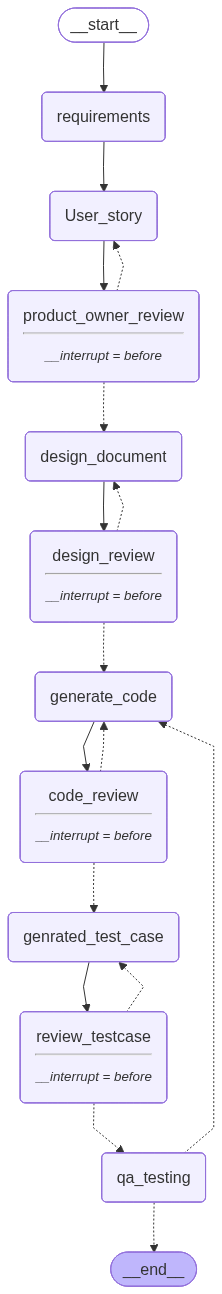

In [23]:
builder = StateGraph(SDLC)

# Add nodes
builder.add_node("requirements", Initial_requirements)
builder.add_node("User_story", User_story)
builder.add_node("product_owner_review", product_owner_review)
builder.add_node("design_document", design_document)
builder.add_node("design_review", design_review)
builder.add_node("generate_code", generate_code)
builder.add_node("code_review", code_review)
builder.add_node("genrated_test_case", genrated_test_case)
builder.add_node("review_testcase", review_testcase)
builder.add_node("qa_testing",qa_testing)

# Add edges
builder.add_edge(START, "requirements")
builder.add_edge("requirements", "User_story")
builder.add_edge("User_story", "product_owner_review")

builder.add_conditional_edges(
    "product_owner_review",
    user_story_routing,
    {
        "design_document": "design_document",
        "User_story": "User_story"
    }
)

builder.add_edge("design_document", "design_review")

builder.add_conditional_edges(
    "design_review",
    design_routing,
    {
        "generate_code": "generate_code",
        "design_document": "design_document"
    }
)

builder.add_edge("generate_code", "code_review")


builder.add_conditional_edges(
    "code_review",
    code_routing,
    {
        "generate_code": "generate_code",
        "genrated_test_case": "genrated_test_case"  
    }
)

builder.add_edge("genrated_test_case", "review_testcase")


builder.add_conditional_edges(
    "review_testcase",
    test_case_routing,
    {
        "genrated_test_case": "genrated_test_case",
        "qa_testing":"qa_testing"
    }
)
builder.add_conditional_edges(
    "qa_testing",
    qa_test_route,
    {END: END, "generate_code": "generate_code"}
)

# Compile
memory = MemorySaver()
graph = builder.compile(
    interrupt_before=['product_owner_review', 'design_review', 'code_review', 'review_testcase'],
    checkpointer=memory
)

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    print("Graph visualization not available")



In [24]:
def diagnostic_test():
    """Run complete workflow with diagnostics including QA testing"""
    config = {"configurable": {"thread_id": "diagnostic-test-complete-qa"}}
    initial_state = SDLC(requirements="Build a login feature with two fatcter authentication")
    
    print("\n" + "🔬" + "="*59)
    print("DIAGNOSTIC TEST - FULL WORKFLOW WITH QA")
    print("="*60)
    
    # Step 1: User story generation
    print("\n📍 STEP 1: Initial run to user story review")
    result = graph.invoke(initial_state, config=config)
    print(f"\n📊 State after step 1:")
    print(f"   User Story: {'✓ EXISTS' if result.get('User_story') else '✗ MISSING'}")
    print(f"   Approval Status: {result.get('approval_status')}")
    
    # Step 2: Design generation
    print("\n" + "="*60)
    print("📍 STEP 2: User story review → Design generation")
    result = graph.invoke(None, config=config)
    print(f"\n📊 State after step 2:")
    print(f"   User Story: {'✓ EXISTS' if result.get('User_story') else '✗ MISSING'}")
    print(f"   Approval Status: {result.get('approval_status')}")
    print(f"   Design Doc: {'✓ EXISTS' if result.get('design_documents') else '✗ MISSING'}")
    print(f"   Design Approval: {result.get('design_approval_status')}")
    
    # Step 3: Code generation
    print("\n" + "="*60)
    print("STEP 3: Design review → Code generation")
    result = graph.invoke(None, config=config)
    print(f"\n State after step 3:")
    print(f"   Design Doc: {'✓ EXISTS' if result.get('design_documents') else '✗ MISSING'}")
    print(f"   Design Approval: {result.get('design_approval_status')}")
    print(f"   Code: {'✓ EXISTS' if result.get('generated_code') else '✗ MISSING'}")
    print(f"   Code Approval: {result.get('code_approval_status')}")
    
    # Step 4: Test case generation
    print("\n" + "="*60)
    print("STEP 4: Code review → Test case generation")
    result = graph.invoke(None, config=config)
    print(f"\nState after step 4:")
    print(f"   Code: {'✓ EXISTS' if result.get('generated_code') else '✗ MISSING'}")
    print(f"   Code Approval: {result.get('code_approval_status')}")
    print(f"   Test Cases: {'✓ EXISTS' if result.get('genrated_test_case') else '✗ MISSING'}")
    print(f"   Test Case Approval: {result.get('testcase_approval_status')}")
    
    # Step 5: QA testing
    print("\n" + "="*60)
    print("STEP 5: Test case review → QA testing")
    result = graph.invoke(None, config=config)
    print(f"\nState after step 5:")
    print(f"   Test Cases: {'✓ EXISTS' if result.get('genrated_test_case') else '✗ MISSING'}")
    print(f"   Test Case Approval: {result.get('testcase_approval_status')}")
    print(f"   QA Test Results: {'✓ EXISTS' if result.get('qa_test_results') else '✗ MISSING'}")
    print(f"   QA Approval: {result.get('qa_approval_status')}")
    
    # Step 6: Final QA approval (if needed)
    print("\n" + "="*60)
    print("STEP 6: QA testing → Final completion")
    result = graph.invoke(None, config=config)
    print(f"\nFINAL State:")
    print(f"   User Story: {'✓ EXISTS' if result.get('User_story') else '✗ MISSING'}")
    print(f"   Design Doc: {'✓ EXISTS' if result.get('design_documents') else '✗ MISSING'}")
    print(f"   Code: {'✓ EXISTS' if result.get('generated_code') else '✗ MISSING'}")
    print(f"   Test Cases: {'✓ EXISTS' if result.get('genrated_test_case') else '✗ MISSING'}")
    print(f"   QA Test Results: {'✓ EXISTS' if result.get('qa_test_results') else '✗ MISSING'}")
    print(f"   QA Approval: {result.get('qa_approval_status')}")
    
    print("\n" + "="*60)
    print(" DIAGNOSTIC TEST COMPLETE")
    print("="*60)
    
    # Show all artifacts
    if result.get('genrated_test_case'):
        print("\nGENERATED TEST CASES:")
        print("="*60)
        print(result['genrated_test_case'])
        print("="*60)
    
    if result.get('qa_test_results'):
        print("\n QA TEST RESULTS:")
        print("="*60)
        print(result['qa_test_results'])
        print("="*60)
    
    return result


# Run the diagnostic test
try:
    result = diagnostic_test()
except Exception as e:
    print(f"\n❌ ERROR: {e}")
    import traceback
    traceback.print_exc()


🔬===========================================================
DIAGNOSTIC TEST - FULL WORKFLOW WITH QA

📍 STEP 1: Initial run to user story review
**User Story:**

As a **Registered User**, 
I want to **login to the application with two-factor authentication**, 
so that **I can securely access my account and sensitive information**.

**Acceptance Criteria:**

1. The application displays a login form with input fields for username and password.
2. The application allows users to enter a valid username and password to proceed to the next step of the login process.
3. The application prompts the user to enter a verification code sent via SMS/email for two-factor authentication.
4. The application validates the verification code entered by the user and allows access to the account if it matches the code sent via SMS/email.
5. The application displays an error message if the username or password is incorrect.
6. The application displays an error message if the verification code is incorrect 